# YamboRestart: a G0W0 run with automated error handling

This is the lowest-level workflow of the plugin. It runs a yambo calculation (*p2y*+*yambo init*+*yambo*) wrapping the `YamboCalculation` class and it implements a restart logic. Possible error handling restart supports:
- Time Exhaustion on the queue: run a new calculation with 50% more time and copying the partial results obtained in the failed one;
- Corruption of the databases: it just restart the calculation deleting the corrupted files but copying all the other outputs, for an efficient restart;
- Parallization errors: use the built-in yambo parallelization logic to attempt a restart;
- Memory limitations: reduce mpi(/2) and increase threads(*2) to attempt a better memory distribution; It can increase number of nodes only if the maximum possible usable nodes (provided as input parameter) is not yet reached, for two cases: if mpi = 1 or if we are using GPU acceleration;
- Redefine parallelism options settings defaults.

after each calculation, the WorkChain will check the exit status of the simulation and, if it is different from zero (i.e. failed), YamboRestart will try to fix some parameters/settings in order to resubmit the calculation and obtain meaningful results. As inputs, it is possible to provide
the maximum number of iterations that the workchain will perform (default is 5) and other parameters, as explained in the following.

In [1]:
from aiida import orm, load_profile
load_profile()

from aiida.plugins import WorkflowFactory
from aiida.engine import submit

import yaml

## Providing the minimal inputs needed for protocols

We have to provide minimal inputs for the creation of the builder instance, namely:
- codes;
- `parent_folder`;

In [3]:
options = {
    'protocol':'fast',
    'parent_id':396, #provide your previously nscf id (pk)
}

In [4]:
# Read YAML file
with open("../configuration/codes_localhost.yaml", 'r') as stream:
    codes = yaml.safe_load(stream)
    
with open("../configuration/resources_localhost.yaml", 'r') as stream:
    resources = yaml.safe_load(stream)

In [5]:
options.update(codes)

The creation of the builder, for a given workflow, is provided by means of the `get_builder_from_protocol` method.
This is, for now, just a way to automatically populated all the needed inputs, allowing the user to partially skip the part of input definition.

However, for GW and BSE simulation, default parameter values for a given level of accuracy are not really tested, so the user should check carefully them before the submission of the simulation.

In [6]:
YamboRestart = WorkflowFactory('yambo.yambo.yamborestart')
builder = YamboRestart.get_builder_from_protocol(
    preprocessing_code = options['yamboprecode_id'],
    code = options['yambocode_id'],
    protocol=options['protocol'],
    overrides={},
    parent_folder=orm.load_node(options['parent_id']).outputs.remote_folder,
    RIM_v=False,           #this automatically set the RIM_cut runlevel, if True
    RIM_W=False,           #this automatically set the RIM_W, if True
    BG_term=False,         #this automatically set the BG terminator parameter, if True
)

Summary of the main inputs:
BndsRnXp = 150
GbndRnge = 150
NGsBlkXp = 6 Ry
FFTGvecs = 21 Ry



You can also inspect the other protocols which are available: 

In [7]:
YamboRestart.get_available_protocols()

{'fast': {'description': 'Under converged for most materials, but fast'},
 'moderate': {'description': 'Meta converged for most materials, higher computational cost than fast'},
 'precise': {'description': 'Converged for most materials, higher computational cost than moderate'},
 'bse_fast': {'description': 'Under converged for most materials, but fast'},
 'bse_moderate': {'description': 'Meta converged for most materials, higher computational cost than fast'},
 'bse_precise': {'description': 'Converged for most materials, higher computational cost than moderate'}}

Now, if you inspect the pre-populated inputs, you can see the default values respecting the imposed protocol:

In [8]:
builder.yambo.parameters.get_dict()

{'arguments': ['dipoles', 'ppa', 'HF_and_locXC', 'gw0'],
 'variables': {'Chimod': 'hartree',
  'DysSolver': 'n',
  'GTermKind': 'BG',
  'X_and_IO_nCPU_LinAlg_INV': [1, ''],
  'NGsBlkXp': [6, 'Ry'],
  'FFTGvecs': [21, 'Ry'],
  'BndsRnXp': [[1, 150], ''],
  'GbndRnge': [[1, 150], ''],
  'QPkrange': [[[1, 1, 32, 32]], '']}}

Let's provide also the resources:

In [9]:
builder.yambo.metadata.options = resources

### Overrides

It is possible to modify the default inputs also during the builder creation phase, so not a posteriori. This can be done by using overrides:

In [13]:
overrides_yambo = {
        "yambo": {
            "parameters": {
                "arguments": [
                    "rim_cut",
                ],
                "variables": {
                    "NGsBlkXp": [4, "Ry"],
                },
            },
    'metadata':{"options":resources},
        }
}

In [14]:
builder = YamboRestart.get_builder_from_protocol(
            preprocessing_code = options['yamboprecode_id'],
            code = options['yambocode_id'],
            protocol=options['protocol'],
            overrides=overrides_yambo,
            parent_folder=orm.load_node(options['parent_id']).outputs.remote_folder,
)

Summary of the main inputs:
BndsRnXp = 150
GbndRnge = 150
NGsBlkXp = 4 Ry
FFTGvecs = 21 Ry



In [15]:
builder.yambo.metadata.options

{'stash': {}, 'resources': {'num_machines': 1, 'num_mpiprocs_per_machine': 1, 'num_cores_per_mpiproc': 1}, 'max_wallclock_seconds': 3600, 'withmpi': True, 'prepend_text': 'export OMP_NUM_THREADS=1'}

In [16]:
builder.yambo.parameters.get_dict()

{'arguments': ['ppa', 'dipoles', 'rim_cut', 'HF_and_locXC', 'gw0'],
 'variables': {'Chimod': 'hartree',
  'DysSolver': 'n',
  'GTermKind': 'BG',
  'X_and_IO_nCPU_LinAlg_INV': [1, ''],
  'NGsBlkXp': [4, 'Ry'],
  'FFTGvecs': [21, 'Ry'],
  'BndsRnXp': [[1, 150], ''],
  'GbndRnge': [[1, 150], ''],
  'QPkrange': [[[1, 1, 32, 32]], '']}}

### Restart settings

It is possible to change defaults values (shown below) of the restart settings:

```python
builder.max_walltime = orm.Int(24*60*60) # maximum walltime.
builder.max_number_of_nodes = orm.Int(0) # maximum number of nodes for a given run; by default, zero will disable the increasing of the nodes.
builder.max_iterations = orm.Int(5) # maximum number of attempt to succesfully done the calculation.
```

### Submission phase

In [17]:
run = None

In [18]:
if run:
    print('run is already running -> {}'.format(run.pk))
    print('sure that you want to run again?, if so, copy the else instruction in the cell below and run!')
else:
    run = submit(builder)

print(run)

uuid: 3ad970df-a265-46a4-b8f1-a2714cec8222 (pk: 419) (aiida.workflows:yambo.yambo.yamborestart)


## Inspecting the outputs

Suppose that your calculation completed successfully, then you can access the outputs via the output method of the run instance. 
This is analogous to the [*1_YamboCalculation_G0W0*](1_YamboCalculation_G0W0.ipynb) module, as the outputs are inerithed from the submitted `YamboCalculation`.

In [21]:
run.is_finished_ok

True

For example, we have the array_ndb ArrayData, which essentially contains the information on the run.output.QP_DB (which can also be accessed directly):

In [22]:
run.outputs.array_ndb.get_arraynames()

['E',
 'Z',
 'Eo',
 'Sc',
 'Sx',
 'Vxc',
 'Band',
 'Kpoint',
 'nbands',
 'nkpoints',
 'qp_table',
 'E_minus_Eo',
 'Kpoint_index']

In [28]:
E_dft = run.outputs.array_ndb.get_array('Eo') 
E_qp = run.outputs.array_ndb.get_array('E')

In [24]:
from matplotlib import pyplot as plt

In [25]:
from ase import units

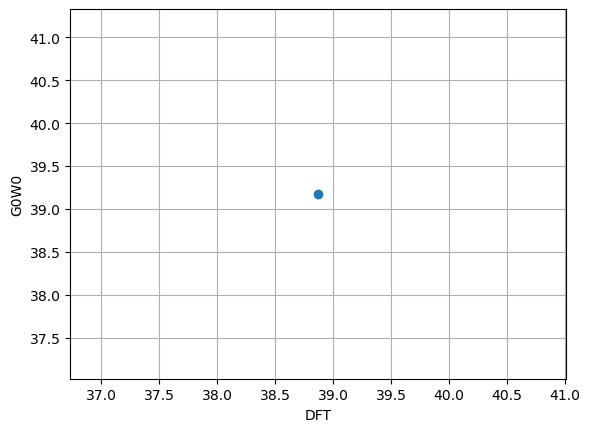

In [29]:
plt.plot(E_dft.real*units.Ha,E_qp.real*units.Ha,'o')
plt.ylabel('G0W0')
plt.xlabel('DFT')
plt.grid()

In [30]:
E_qp

array([1.4396821-0.0039867j], dtype=complex64)

In [31]:
run.outputs.output_parameters.get_dict()

{'errors': [],
 'timing': [' <---> [01] MPI/OPENMP structure, Files & I/O Directories\n',
  ' <---> [02] CORE Variables Setup\n',
  ' <---> [03] Transferred momenta grid and indexing\n',
  ' <---> [04] Dipoles\n',
  ' <02s> [05] Dynamic Dielectric Matrix (PPA)\n',
  ' <18s> [06] Local Exchange-Correlation + Non-Local Fock\n',
  ' <19s> [07] Dyson equation: Newton solver\n',
  ' <22s> [08] Timing Overview\n',
  ' <22s> [09] Game Over & Game summary\n'],
 'has_gpu': False,
 'memstats': [],
 'warnings': [],
 'Fermi(eV)': 6.467203,
 'game_over': True,
 'last_time': 22,
 'para_error': False,
 'time_error': False,
 'ns_db1_path': '/tmp/tmp6555qcd0',
 'memory_error': False,
 'p2y_completed': True,
 'yambo_version': '5.x',
 'requested_time': 3600,
 'last_time_units': 'seconds',
 'yambo_wrote_dbs': True,
 'corrupted_fragment': False,
 'X_par_allocation_error': False}

In [32]:
run.outputs.QP_db

<SinglefileData: uuid: 29f20a0d-ae22-4650-86cc-0389048291c5 (pk: 423)>

## Error handling in action: the case of walltime exhaustion

You can try the restaring mechanism by asking for a very small time for the simulation, in such a way that the first run will not be completed successfully. 
You can see, by inspecting the report of the run, that the workflow submits restart calculations by increasing the walltime.

In [33]:
overrides_yambo = {
        "yambo": {
            "parameters": {
                "arguments": [
                    "rim_cut",
                ],
                "variables": {
                    "NGsBlkXp": [12, "Ry"],
                },
            },
    'metadata':{
                    'options':{
    'max_wallclock_seconds': 10, # in seconds
    'resources': {
            "num_machines": 1, # nodes
            "num_mpiprocs_per_machine": 1, # MPI per nodes
            "num_cores_per_mpiproc": 1, # OPENMP
        },
    'prepend_text': u"export OMP_NUM_THREADS="+str(1), # if needed
    #'account':'project_name',
    #'queue_name':'s3par',
    #'qos':'',
                    },
    },
        }
}

builder = YamboRestart.get_builder_from_protocol(
            preprocessing_code = options['yamboprecode_id'],
            code = options['yambocode_id'],
            protocol=options['protocol'],
            overrides=overrides_yambo,
            parent_folder=orm.load_node(options['parent_id']).outputs.remote_folder,
)

Summary of the main inputs:
BndsRnXp = 150
GbndRnge = 150
NGsBlkXp = 12 Ry
FFTGvecs = 21 Ry



In [34]:
builder.yambo.metadata

{'options': {'stash': {}, 'resources': {'num_machines': 1, 'num_mpiprocs_per_machine': 1, 'num_cores_per_mpiproc': 1}, 'max_wallclock_seconds': 10, 'withmpi': True, 'prepend_text': 'export OMP_NUM_THREADS=1'}}

In [35]:
run = None

In [36]:
if run:
    print('run is already running -> {}'.format(run.pk))
    print('sure that you want to run again?, if so, copy the else instruction in the cell below and run!')
else:
    run = submit(builder)

print(run)

uuid: f9fba6d7-c2b2-4692-b02e-16b8c630dd4e (pk: 434) (aiida.workflows:yambo.yambo.yamborestart)


In [37]:
print(run.pk)

434


In [57]:
run.is_finished

True

In [58]:
!verdi process report {run.pk}

2024-02-14 18:40:20 [10 | REPORT]: [434|YamboRestart|run_process]: launching YamboCalculation<435> iteration #1
2024-02-14 18:41:26 [13 | REPORT]: [434|YamboRestart|report_error_handled]: YamboCalculation<435> failed with exit status 501: time exceeded the max walltime
2024-02-14 18:41:26 [14 | REPORT]: [434|YamboRestart|report_error_handled]: Action taken: walltime error detected, so we increase time: 15                                                 seconds and link outputs
2024-02-14 18:41:26 [15 | REPORT]: [434|YamboRestart|inspect_process]: YamboCalculation<435> failed but a handler dealt with the problem, restarting
2024-02-14 18:41:26 [16 | REPORT]: [434|YamboRestart|run_process]: launching YamboCalculation<440> iteration #2
2024-02-14 18:42:01 [17 | REPORT]: [434|YamboRestart|results]: work chain completed after 2 iterations
2024-02-14 18:42:01 [18 | REPORT]: [434|YamboRestart|on_terminated]: remote folders will not be cleaned
